In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from scipy.fft import fft, fftfreq,rfft,fftshift,rfftfreq
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
import seaborn as sb
from utilities import *
from sklearn.decomposition import PCA
import pickle
from sklearn.metrics import f1_score

Skup podataka i pretprocesiranje

In [30]:
df=pd.read_csv('dataset.csv')
df.drop('Unnamed',axis=1,inplace=True)
df['y'].replace({1:1,2:0,3:0,4:0,5:0},inplace=True)
x=df.drop(columns=['y'])
y=df['y']
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,135,190,229,223,192,125,55,-9,-33,-38,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,0
1,386,382,356,331,320,315,307,272,244,232,...,164,150,146,152,157,156,154,143,129,1
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,57,64,48,19,-12,-30,-35,-35,-36,0
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,0
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,4,2,-12,-32,-41,-65,-83,-89,-73,0


Razlika između snimaka tokom i van napada

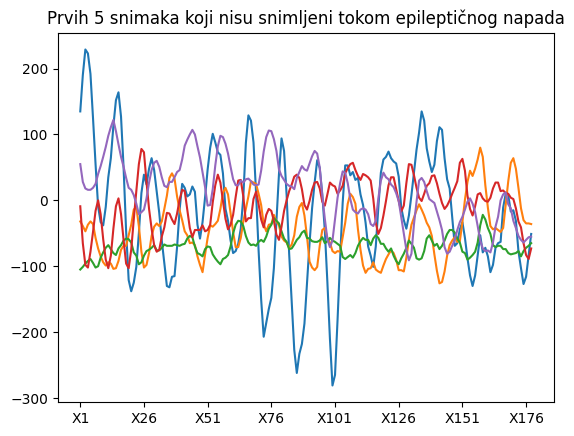

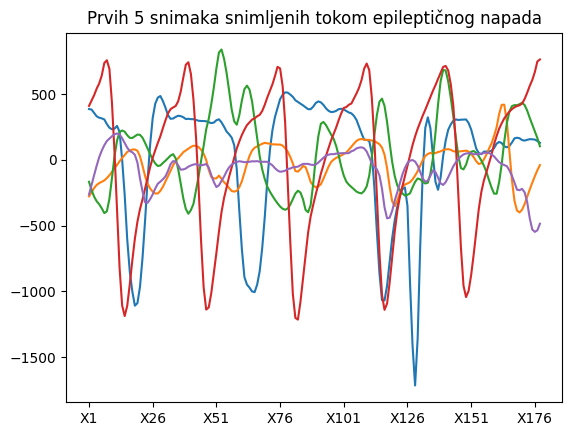

In [31]:
df2=df[df['y']==0].iloc[:5]
df2.T.iloc[:-1].plot(legend=None)
plt.title("Prvih 5 snimaka koji nisu snimljeni tokom epileptičnog napada")
plt.show()

df2=df[df['y']==1].iloc[:5]
df2.T.iloc[:-1].plot(legend=None)
plt.title("Prvih 5 snimaka snimljenih tokom epileptičnog napada")
plt.show()

Poređenje modela dobijenih različitim izdvajanjem osobina

Statističke osobine (statistical features)

In [32]:
normalized_signal=pd.DataFrame(preprocessing.normalize(x),columns=df.columns[:-1])

stat_features=pd.DataFrame()
stat_features['std']=x.std(axis='columns')
stat_features['mean']=x.mean(axis='columns')
stat_features['first difference']=x.diff(axis='columns').abs().T.mean()
stat_features['first difference normalized']=normalized_signal.diff(axis='columns').diff(axis='columns').abs().T.mean()
stat_features['second difference']=x.diff(axis='columns').diff(axis='columns').abs().T.mean()
stat_features['second difference normalized']=normalized_signal.diff(axis='columns').abs().T.mean()
stat_features['y']=y

stat_features

,std,mean,first difference,first difference normalized,second difference,second difference normalized,y
0,95.980947,-16.910112,32.203390,0.017137,22.221591,0.024834,0
1,473.166815,28.112360,79.316384,0.007222,45.545455,0.012577,1
2,44.311025,-44.044944,13.887006,0.012792,10.647727,0.016684,0
3,15.968642,-68.910112,6.056497,0.006503,6.136364,0.006418,0
4,38.802149,-6.651685,15.468927,0.023886,12.511364,0.029532,0
...,...,...,...,...,...,...,...
11495,38.376487,5.157303,5.536723,0.008481,4.369318,0.010747,0
11496,163.538573,5.674157,32.118644,0.006245,13.596591,0.014753,1
11497,44.289439,6.752809,17.468927,0.032838,19.573864,0.029306,0
11498,63.607269,-38.842697,12.672316,0.010828,10.744318,0.012771,0


Podela na trening i test skup podataka i skaliranje podataka

In [33]:
stat_x_train, stat_x_test, stat_y_train, stat_y_test = train_test_split(stat_features.drop(columns=['y']), stat_features['y'], train_size=0.8, random_state=42, shuffle=True)

scaler = StandardScaler()
stat_x_train = scaler.fit_transform(stat_x_train)
stat_x_test = scaler.transform(stat_x_test)

Pronalaženje najboljih parametara za SVC algoritam

In [34]:
svc=SVC()
svc.fit(stat_x_train,stat_y_train)
y_pred=svc.predict(stat_x_test)
print(f"Rezultati nad test podacima sa podrazumevanim parametrima: {f1_score(stat_y_test,y_pred)}")

stat_gs_result=find_best_svc_params(stat_x_train,stat_y_train,'stat_gs_result.pkl',False)
print(f"Pronađeni parametri: {stat_gs_result.best_params_}")
print(f"Rezultati nad test podacima sa pronađenim parametrima {stat_gs_result.score(stat_x_test,stat_y_test)}")

Rezultati nad test podacima sa podrazumevanim parametrima: 0.9530054644808744
Fitting 5 folds for each of 35 candidates, totalling 175 fits
Pronađeni parametri: {'C': 100.0, 'gamma': 0.1, 'kernel': 'rbf'}
Rezultati nad test podacima sa pronađenim parametrima 0.9555796316359696


Autoregresioni model (Autoregressive model)

In [35]:
def find_ar_params(order):
    rows=[]
    for i in range(len(x)):
        model=AutoReg(x.iloc[i].values,lags=order).fit()
        row={}
        for j in range(1,order+1):
            row[f"param {j}"]=model.params[j]
        row['y']=y.iloc[i]
        rows.append(row)
    ar_model_params=pd.DataFrame(rows)
    return ar_model_params

start_order=6
end_order=15

ar_params=[find_ar_params(i) for i in range(start_order,end_order+1)]

Podela na trening i test skup podataka i skaliranje podataka

In [36]:
ar_params_split=[]

for order in ar_params:
    row={}
    x_train, x_test, y_train, y_test = train_test_split(order.drop(columns=['y']), order['y'], train_size=0.8, random_state=42, shuffle=True)
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    
    row['x_train']=x_train
    row['x_test']=x_test
    row['y_train']=y_train
    row['y_test']=y_test
    ar_params_split.append(row)
    

Pronalaženje najboljeg reda autoregresivnog modela

In [37]:
i=start_order
for order in ar_params_split:
    print(f"Autoregresivni model {i}. reda:")
    svc=SVC()
    svc.fit(order['x_train'],order['y_train'])
    y_pred=svc.predict(order['x_test'])
    print(f"Rezultati nad test podacima sa podrazumevanim parametrima: {f1_score(order['y_test'],y_pred)}")
    i+=1

Autoregresivni model 6. reda:
Rezultati nad test podacima sa podrazumevanim parametrima: 0.8013856812933025
Autoregresivni model 7. reda:
Rezultati nad test podacima sa podrazumevanim parametrima: 0.8439181916038752
Autoregresivni model 8. reda:
Rezultati nad test podacima sa podrazumevanim parametrima: 0.8770764119601328
Autoregresivni model 9. reda:
Rezultati nad test podacima sa podrazumevanim parametrima: 0.9210810810810811
Autoregresivni model 10. reda:
Rezultati nad test podacima sa podrazumevanim parametrima: 0.9210810810810811
Autoregresivni model 11. reda:
Rezultati nad test podacima sa podrazumevanim parametrima: 0.9209100758396533
Autoregresivni model 12. reda:
Rezultati nad test podacima sa podrazumevanim parametrima: 0.9308855291576673
Autoregresivni model 13. reda:
Rezultati nad test podacima sa podrazumevanim parametrima: 0.9320388349514563
Autoregresivni model 14. reda:
Rezultati nad test podacima sa podrazumevanim parametrima: 0.9227421109902069
Autoregresivni model 15

Značajan porast performansi se dobija za autoregresioni model 9. reda, pa će on i biti korišćen

In [59]:
pd.options.display.max_columns=10

ar_params[3].head()

,param 1,param 2,param 3,param 4,param 5,param 6,param 7,param 8,param 9,y
0,1.799194,-1.236149,0.471866,-0.277166,0.143407,-0.160677,0.383797,-0.476758,0.280706,0
1,2.359503,-1.870375,-0.024665,0.839523,-0.017498,-0.799979,0.654732,-0.153122,-0.030083,1
2,1.863347,-1.020008,-0.304618,0.505719,0.054329,-0.450578,0.576019,-0.531668,0.239977,0
3,1.393142,-0.446079,-0.185518,0.043323,-0.129492,0.122872,0.433563,-0.726335,0.348840,0
4,1.805872,-1.105084,-0.124611,0.453396,-0.224083,0.029946,0.294643,-0.434997,0.228030,0


In [48]:
ar_x_train=ar_params_split[3]['x_train']
ar_x_test=ar_params_split[3]['x_test']
ar_y_train=ar_params_split[3]['y_train']
ar_y_test=ar_params_split[3]['y_test']

ar_gs_result=find_best_svc_params(ar_x_train,ar_y_train,'ar_gs_result.pkl',True)
print(f"Pronađeni parametri: {ar_gs_result.best_params_}")
print(f"Rezultati nad test podacima sa pronađenim parametrima {ar_gs_result.score(ar_x_test,ar_y_test)}")

Pronađeni parametri: {'C': 90, 'gamma': 0.1, 'kernel': 'rbf'}
Rezultati nad test podacima sa pronađenim parametrima 0.9496248660235799


Furieova transformacija

In [55]:
rows=[]
for i in range(len(x)):
    frequencies=rfft(x.iloc[i])
    row={str(i+1):frequencies[i] for i in range(0,len(frequencies))}
    row['y']=y.iloc[i]
    rows.append(row)
f_transform=pd.DataFrame(rows)

pd.options.display.max_columns=6

f_transform.head()

,1,2,3,...,89,90,y
0,-3010.0+ 0.0j,2446.790792+ 450.260364j,-2657.829269- 1481.143752j,...,93.600757+ 9.450320j,44.0+ 0.0j,0
1,5004.0+ 0.0j,1307.724581-7404.532738j,15020.767668+ 7130.189030j,...,151.153163+134.988788j,50.0+ 0.0j,1
2,-7840.0+ 0.0j,936.496752- 664.893496j,440.289506+ 2359.520081j,...,-9.148489- 9.209289j,-28.0+ 0.0j,0
3,-12266.0+ 0.0j,-654.541662+ 10.781029j,85.298621+ 611.952118j,...,-33.001732+ 13.067275j,-22.0+ 0.0j,0
4,-1184.0+ 0.0j,-1599.385327+2043.789895j,-685.634998+ 245.900831j,...,19.383760+ 30.722072j,62.0+ 0.0j,0


Amplitude frekvencija dobijenih Furieovom transformacijom

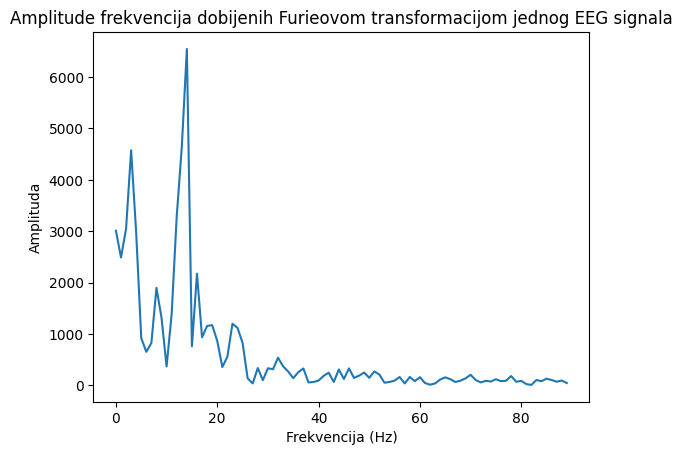

In [40]:
y_plt=f_transform.drop(columns=['y']).iloc[0]
xf = rfftfreq(178, 1 / 178)

plt.plot(xf, np.abs(y_plt))
plt.title("Amplitude frekvencija dobijenih Furieovom transformacijom jednog EEG signala")
plt.xlabel("Frekvencija (Hz)")
plt.ylabel("Amplituda")
plt.show()

Kako ne utiču sve frekvenicje pojednako, neke se mogu zanemariti. To ćemo postići pimenom PCA algoritma.

Prvo treba normalizovati i centrirati podatke

In [41]:
scaler = StandardScaler(with_mean=True, with_std=True)
x_scaled = scaler.fit_transform(abs(f_transform.drop(columns=['y'])))
f_transform_scaled = pd.DataFrame(x_scaled, columns=f_transform.drop(columns=['y']).columns)
f_transform_scaled['y']=f_transform['y'].values

f_transform_scaled.head()

,1,2,3,4,5,6,7,8,9,10,...,82,83,84,85,86,87,88,89,90,y
0,-0.344121,-0.193237,-0.039029,0.373862,0.011019,-0.386044,-0.419142,-0.368016,-0.109855,-0.220821,...,-0.499622,-0.628861,0.164523,-0.029662,0.378549,0.154155,-0.119759,0.082682,-0.269257,0
1,0.148208,1.130895,3.012840,6.436967,3.787436,2.638226,0.590857,2.759044,4.239005,1.355412,...,1.138207,0.076733,0.736913,1.270884,0.465817,0.111823,1.369281,0.964424,-0.220959,1
2,0.848432,-0.545729,-0.183355,-0.363023,-0.308743,-0.322462,-0.381100,-0.271332,-0.185840,-0.199373,...,-0.354202,-0.480490,-0.560764,-0.421313,-0.561508,-0.481237,-0.656533,-0.575875,-0.398054,0
3,1.941235,-0.675713,-0.583781,-0.547735,-0.482937,-0.522743,-0.501774,-0.406869,-0.618947,-0.516972,...,-0.472133,-0.494469,-0.485868,-0.463959,-0.578741,-0.507197,-0.621783,-0.393047,-0.446352,0
4,-0.794971,-0.164989,-0.558950,-0.407993,-0.432949,-0.367846,-0.447550,-0.432510,-0.470656,-0.341147,...,-0.418452,-0.483109,-0.398351,-0.107783,-0.245112,-0.233765,-0.339121,-0.386296,-0.124362,0


ukupna varijansa: 86.8%


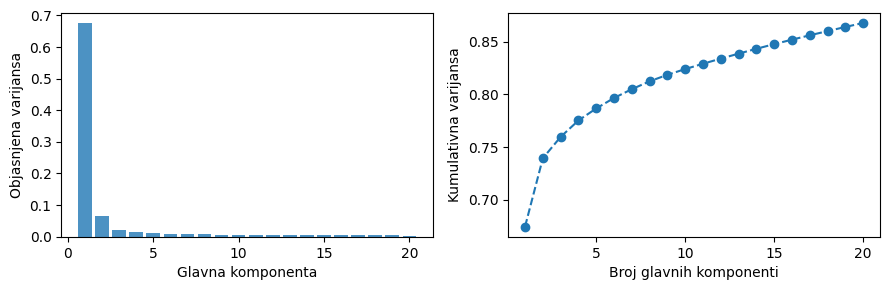

In [42]:
f_transform_pca = PCA(n_components=20, random_state=42)
f_transform_components = f_transform_pca.fit_transform(f_transform_scaled.drop(columns=['y']))
print(f'ukupna varijansa: {sum(f_transform_pca.explained_variance_ratio_) * 100:.1f}%')

plot_explained_variance(f_transform_pca)

ukupna varijansa: 78.7%


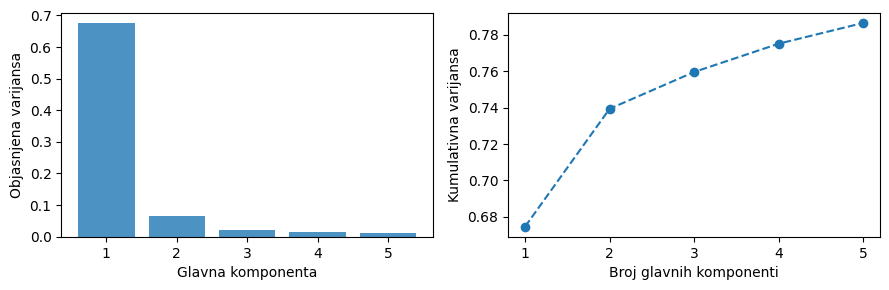

In [43]:
f_transform_pca = PCA(n_components=5, random_state=42)
f_transform_components = f_transform_pca.fit_transform(f_transform_scaled.drop(columns=['y']))
print(f'ukupna varijansa: {sum(f_transform_pca.explained_variance_ratio_) * 100:.1f}%')

plot_explained_variance(f_transform_pca)

Podela na trening i test skup podataka nad različitim brojevima komponenti PCA algoritma

In [44]:
ft_components_split=[]
for components_count in range(1,6):
  f_transform_pca = PCA(n_components=components_count, random_state=42)
  f_transform_components = f_transform_pca.fit_transform(f_transform_scaled.drop(columns=['y']))

  row={}
  x_train, x_test, y_train, y_test = train_test_split(f_transform_components, y, train_size=0.8, random_state=42, shuffle=True)
  scaler = StandardScaler()
  x_train = scaler.fit_transform(x_train)
  x_test = scaler.transform(x_test)

  row['x_train']=x_train
  row['x_test']=x_test
  row['y_train']=y_train
  row['y_test']=y_test
  ft_components_split.append(row)

Pronalaženje najboljeg broja komponenti PCA algotirma za SVC algoritam

In [45]:
i=1
for components in ft_components_split:
    print(f"Broj PCA komponenti: {i}")
    svc=SVC()
    svc.fit(components['x_train'],components['y_train'])
    y_pred=svc.predict(components['x_test'])
    print(f"Rezultati nad test podacima sa podrazumevanim parametrima: {f1_score(components['y_test'],y_pred)}")
    i+=1

Broj PCA komponenti: 1
Rezultati nad test podacima sa podrazumevanim parametrima: 0.7878048780487806
Broj PCA komponenti: 2
Rezultati nad test podacima sa podrazumevanim parametrima: 0.9331872946330777
Broj PCA komponenti: 3
Rezultati nad test podacima sa podrazumevanim parametrima: 0.9337606837606837
Broj PCA komponenti: 4
Rezultati nad test podacima sa podrazumevanim parametrima: 0.9465648854961833
Broj PCA komponenti: 5
Rezultati nad test podacima sa podrazumevanim parametrima: 0.9555796316359696


Za više od dve komponente se dobija sličan rezultat, pa će dve i biti korišćene

Pronalaženje najboljih parametara za SVC algoritam

In [46]:
ft2_x_train=ft_components_split[1]['x_train']
ft2_x_test=ft_components_split[1]['x_test']
ft2_y_train=ft_components_split[1]['y_train']
ft2_y_test=ft_components_split[1]['y_test']

ft2_gs_result=find_best_svc_params(ft2_x_train,ft2_y_train,'ft2_gs_result.pkl',True)
print(f"Pronađeni parametri: {ft2_gs_result.best_params_}")
print(f"Rezultati nad test podacima sa pronađenim parametrima {ft2_gs_result.score(ft2_x_test,ft2_y_test)}")

Pronađeni parametri: {'C': 110, 'gamma': 0.1, 'kernel': 'rbf'}
Rezultati nad test podacima sa pronađenim parametrima 0.9359391965255157


Kako je model sa 5 komponenti i dalje jednostavan, ponovo vršimo traženje parametara

In [47]:
ft5_x_train=ft_components_split[4]['x_train']
ft5_x_test=ft_components_split[4]['x_test']
ft5_y_train=ft_components_split[4]['y_train']
ft5_y_test=ft_components_split[4]['y_test']

ft5_gs_result=find_best_svc_params(ft5_x_train,ft5_y_train,'ft5_gs_result.pkl',True)
print(f"Pronađeni parametri: {ft5_gs_result.best_params_}")
print(f"Rezultati nad test podacima sa pronađenim parametrima {ft5_gs_result.score(ft5_x_test,ft5_y_test)}")

Pronađeni parametri: {'C': 110, 'gamma': 0.1, 'kernel': 'rbf'}
Rezultati nad test podacima sa pronađenim parametrima 0.9622437971952535
